<a href="https://colab.research.google.com/github/golnazads/ColabNotebooks/blob/main/time_series_forecasting_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import datetime
import random
from sklearn.preprocessing import LabelEncoder

# load data
df = pd.read_csv('sample_data/citations_3.csv')

# only consider full year
df = df[df['year'] < 2023]

# df = df[df['citations'] > 0]

# remove outliers
# get value counts and filter
value_counts = df['citations'].value_counts()
# use the counts if their frequency is > 3 or if citation count  is < 1000
mask = value_counts[(value_counts > 1) | (value_counts.index < 1500)].index
# apply the mask to the dataframe
df = df[df['citations'].isin(mask)]

# generate additional columns with random values
day = np.random.randint(1,29,len(df))
hour = np.random.randint(0,24,len(df))
min = np.random.randint(0,60,len(df))
sec = np.random.randint(0,60,len(df))
# Construct full datetime strings
df['date_time'] = df['year'].astype(str) + '-' + \
                  df['month'].astype(str) + '-' + \
                  day.astype(str) + ' ' + \
                  hour.astype(str) + ':' + \
                  min.astype(str) + ':' + \
                  sec.astype(str)
# also compute quarter
df['date_time'] = pd.to_datetime(df['date_time'])
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)

# encode the journal names as integers
# extract bibstem and encode it as integer
label_encoder = LabelEncoder()
df['pub'] = label_encoder.fit_transform(df['bibcode'].str[4:9].str.strip('.'))

df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)

# compute sum of citation for every month/year/publication
df_grouped = df.groupby(['year', 'month', 'pub', 'impact_factor'])['citations'].agg([('sum_citations', 'sum'), ('mean_citations', 'mean'), ('num_pub', 'count')])
df = pd.merge(df, df_grouped, on=['year', 'month', 'pub', 'impact_factor'], how='outer')

df=df.loc[:,['date_time','year','quarter','month', 'pub', 'impact_factor', 'mean_citations', 'sum_citations', 'num_pub']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)

print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.tail(5)

(2243508, 9)
1980-01-01 00:03:10
2022-12-28 23:58:33


,date_time,year,quarter,month,pub,impact_factor,mean_citations,sum_citations,num_pub
2243503,2022-12-28 23:36:34,2022,4,12,78,0.00,0.000000,0,2620
2243504,2022-12-28 23:38:50,2022,4,12,2580,7.10,4.395137,1446,329
2243505,2022-12-28 23:45:57,2022,4,12,2519,0.17,0.104089,28,269
2243506,2022-12-28 23:46:51,2022,4,12,78,0.00,0.000000,0,2620
2243507,2022-12-28 23:58:33,2022,4,12,321,1.72,1.188679,63,53


In [ ]:
from scipy import stats

stat, p = stats.normaltest(df.sum_citations)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=1425234.577, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 10.14280438111387
Skewness of normal distribution: 3.072992596766085


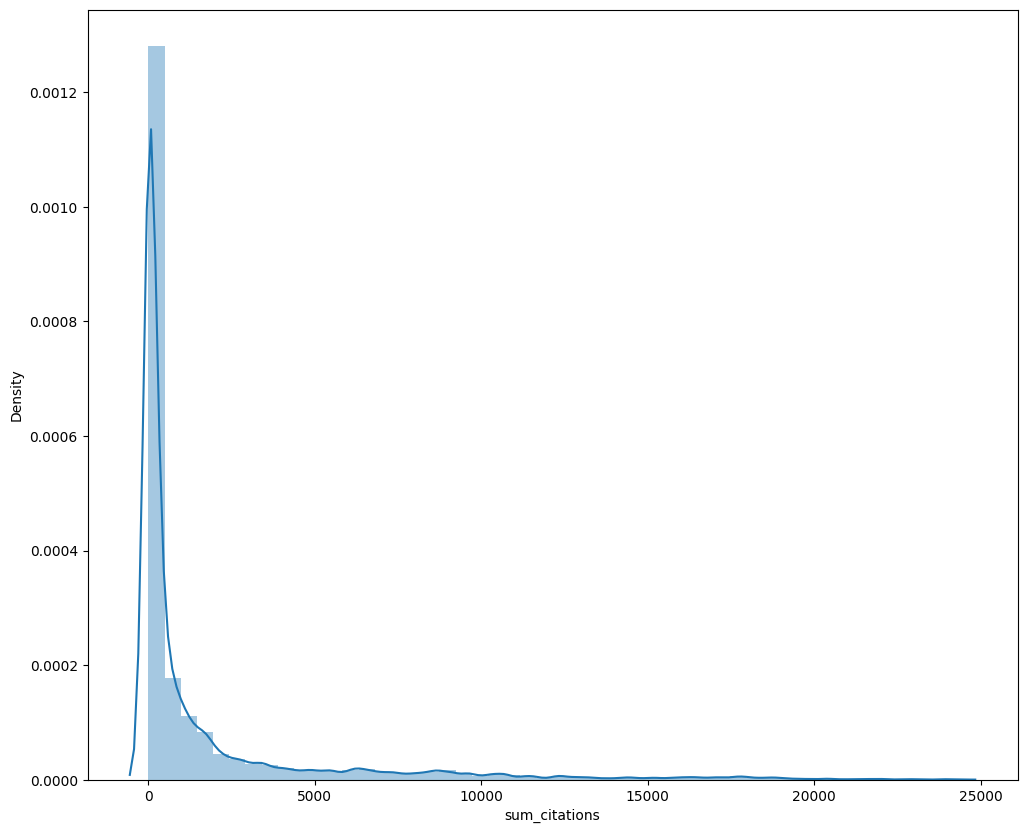

In [ ]:
import seaborn as sns

sns.distplot(df.sum_citations);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.sum_citations)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.sum_citations)))

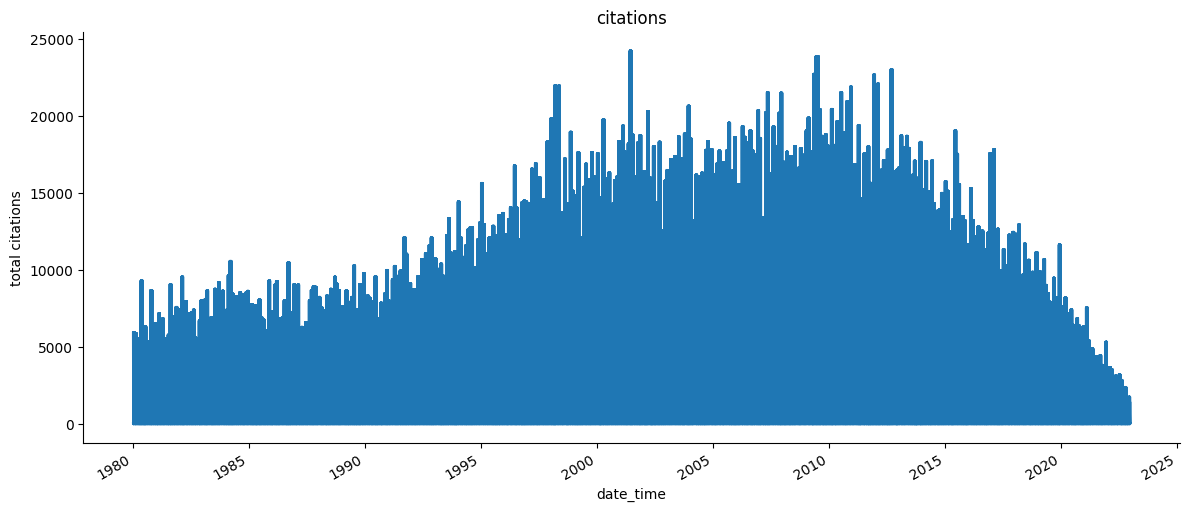

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df1=df.loc[:,['date_time', 'sum_citations']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('total citations')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('citations')
sns.despine(top=True)
plt.show();

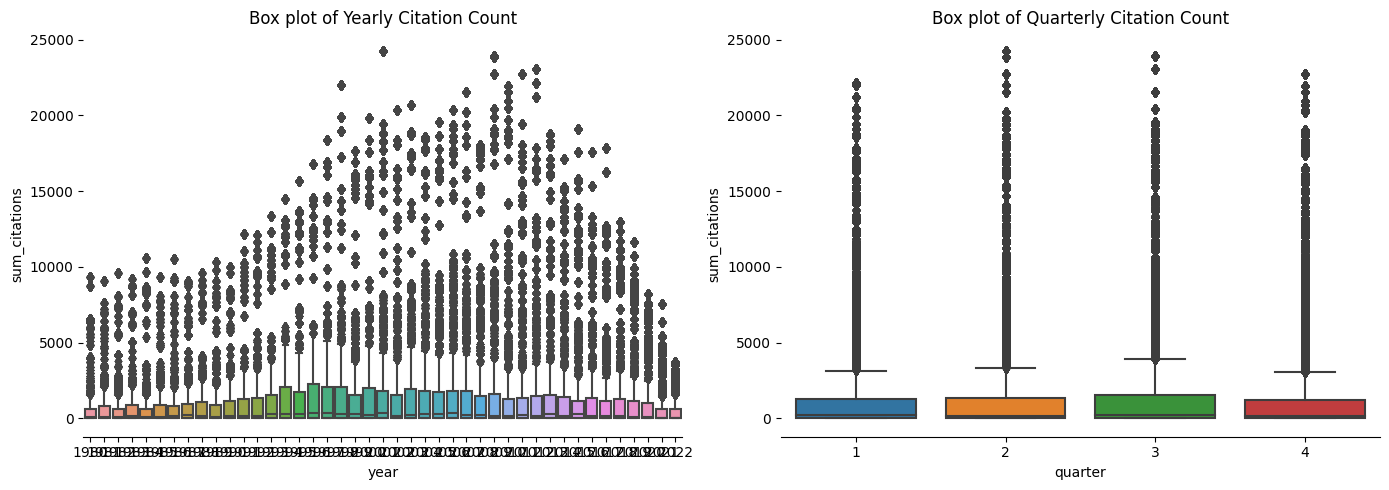

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="sum_citations", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Citation Count')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="sum_citations", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Citation Count')
sns.despine(left=True)
plt.tight_layout();

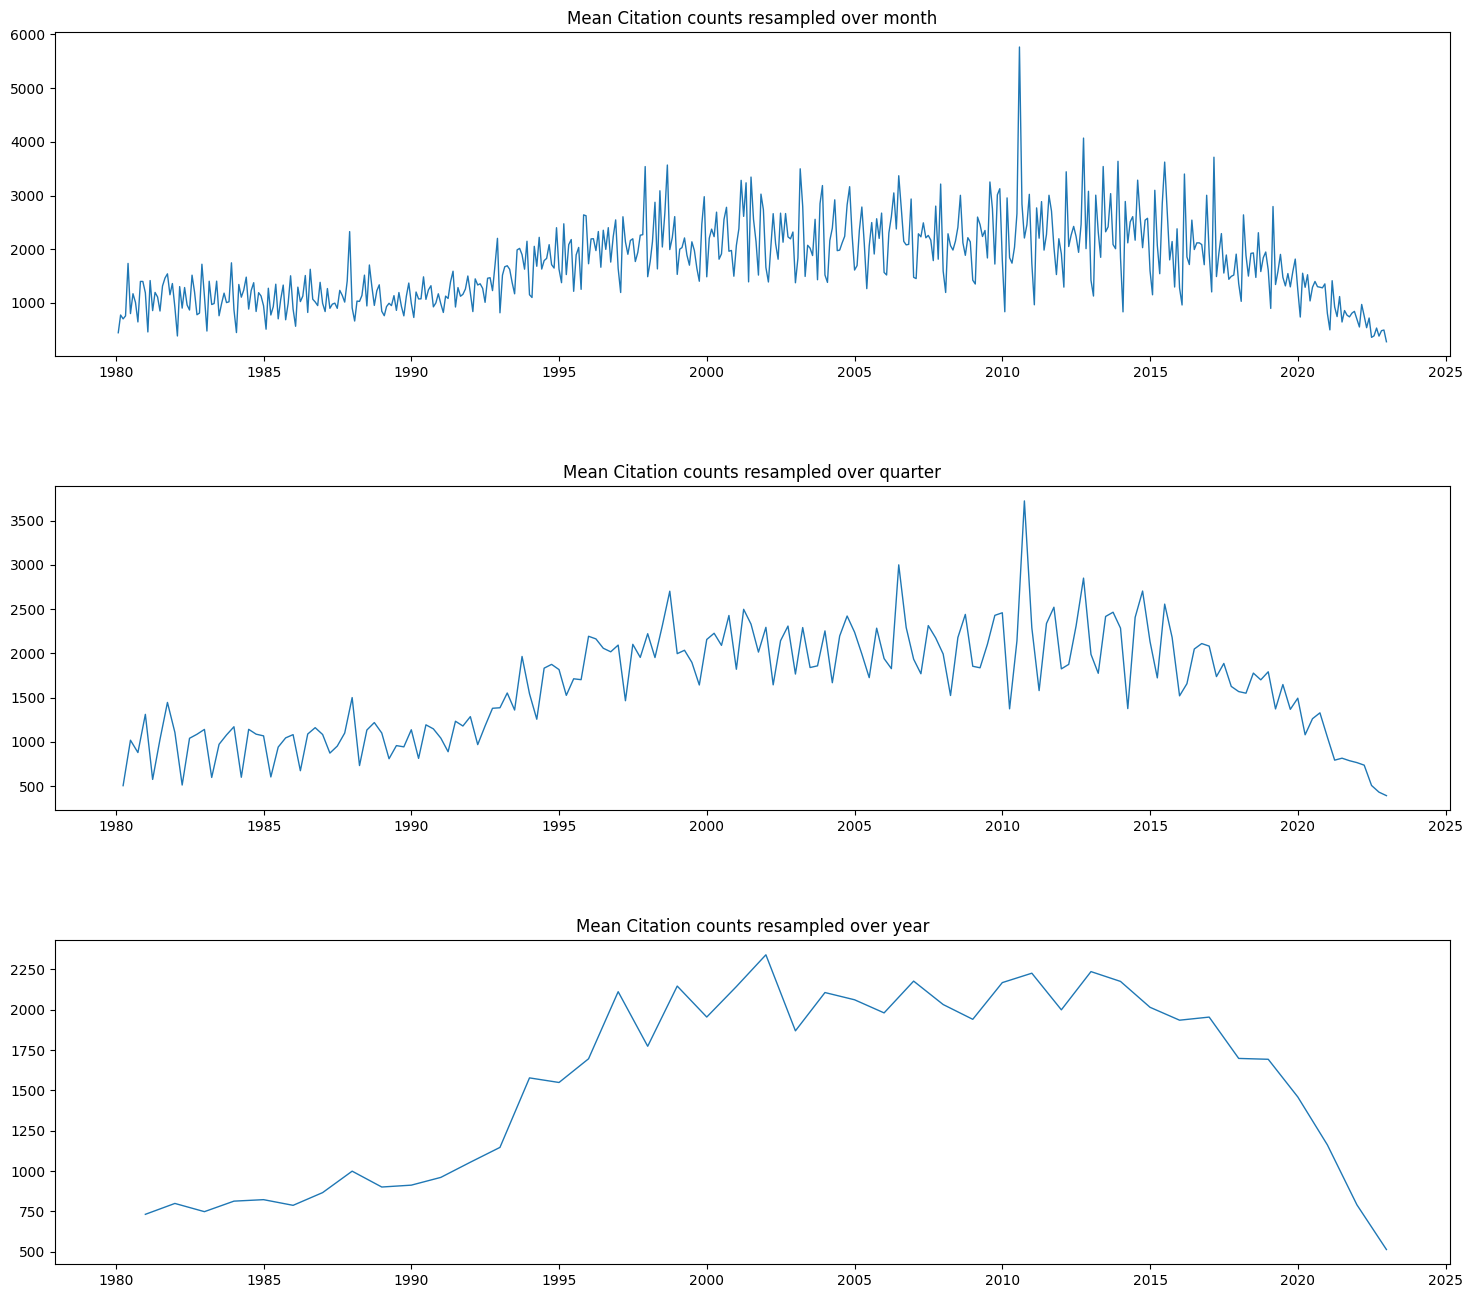

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(3,1,1)
ax1.plot(df1['sum_citations'].resample('M').mean(),linewidth=1)
ax1.set_title('Mean Citation counts resampled over month')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.plot(df1['sum_citations'].resample('Q').mean(),linewidth=1)
ax2.set_title('Mean Citation counts resampled over quarter')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
ax3.plot(df1['sum_citations'].resample('A').mean(),linewidth=1)
ax3.set_title('Mean Citation counts resampled over year')
ax3.tick_params(axis='both', which='major');

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

feature = ['pub', 'num_pub', 'impact_factor']
data = df[feature + ['year', 'month', 'mean_citations', 'sum_citations']]

# remove duplicates, to create previous months' columns
data = data.drop_duplicates()

# get the aggregated rows and make sure data is ordered by year, month
data.sort_values(by=['year', 'month'], inplace=True, ascending=True)
data = data.reset_index(drop=True)

# include citation for the past 2 months
sum_citations_cols = ['sum_citations'] + ['sum_citations_minus_%d'%i for i in range(1,3,1)]

# groupby year, month and journal, then shift the citaiton count backwards to have previous months' values
for i in range(len(sum_citations_cols)-1):
  new_column = data.sort_values(['year', 'month', 'pub']).groupby(['pub'])[sum_citations_cols[i]].shift(1).fillna(0).astype(int)
  data[sum_citations_cols[i+1]] = new_column

data.sort_values(by=['year', 'month'], inplace=True, ascending=True)
data = data.reset_index(drop=True)

# target
y = data['mean_citations'].values

# reverse the sum citation colums so that it would be on the order of increasing months
feature = feature + sum_citations_cols[::-1]
data = data[feature + ['year', 'month']]

# drop rows where all values in the specified columns are zero
# data = data.loc[(data[sum_citations_cols] != 0).all(axis=1)]

# scale features
scaler = MinMaxScaler(feature_range=(0, 1))
data[feature] = scaler.fit_transform(data[feature])

# structure features as 3D input
X = data[feature].values.reshape(-1, 1, len(feature))

# train test split
split = data.loc[data['year'] > 2010].index[0]
# split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print('train/test shapes:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

input_shape = (X_train.shape[1], X_train.shape[2])

# fit LSTM
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=input_shape))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(64))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=200, batch_size=512,
                    validation_data=(X_test, y_test), callbacks=[early_stop])

# forecast
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_train_pred[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, y_train_pred[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_test_pred[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_test_pred[:,0])))

train/test shapes: (92097, 1, 6) (92097,) (32952, 1, 6) (32952,)
Epoch 1/200
180/180 [==============================] - 43s 213ms/step - loss: 3622.4097 - val_loss: 1344.4352
Epoch 2/200
180/180 [==============================] - 37s 208ms/step - loss: 3042.8105 - val_loss: 1314.3590
Epoch 3/200
180/180 [==============================] - 39s 215ms/step - loss: 2475.1382 - val_loss: 929.0795
Epoch 4/200
180/180 [==============================] - 38s 211ms/step - loss: 1774.8607 - val_loss: 687.8548
Epoch 5/200
180/180 [==============================] - 37s 205ms/step - loss: 1408.4027 - val_loss: 647.1658
Epoch 6/200
180/180 [==============================] - 37s 207ms/step - loss: 1221.3800 - val_loss: 530.8671
Epoch 7/200
180/180 [==============================] - 37s 207ms/step - loss: 1104.4679 - val_loss: 513.6271
Epoch 8/200
180/180 [==============================] - 38s 210ms/step - loss: 1045.2694 - val_loss: 522.9628
Epoch 9/200
180/180 [==============================] - 37s 20

In [ ]:
import numpy as np

correlation = np.corrcoef(df['impact_factor'], df['sum_citations'])
print("Correlation between column impact_factor and sum_citations:", correlation)

correlation = np.corrcoef(df['mean_citations'], df['sum_citations'])
print("Correlation between column mean_citations and sum_citations:", correlation)

correlation = np.corrcoef(df['impact_factor'], df['mean_citations'])
print("Correlation between column impact_factor and mean_citations:", correlation)

correlation = np.corrcoef(data['sum_citations_minus_1'], data['sum_citations'])
print("Correlation between column sum_citations_minus_1 and sum_citations:", correlation)

correlation = np.corrcoef(data['sum_citations_minus_2'], data['sum_citations'])
print("Correlation between column sum_citations_minus_2 and sum_citations:", correlation)

correlation = np.corrcoef(data['sum_citations_minus_1'], data['sum_citations_minus_2'])
print("Correlation between column sum_citations_minus_1 and sum_citations_minus_2:", correlation)


Correlation between column impact_factor and sum_citations: [[1.         0.49030042]
 [0.49030042 1.        ]]
Correlation between column mean_citations and sum_citations: [[1.         0.52565034]
 [0.52565034 1.        ]]
Correlation between column impact_factor and mean_citations: [[1.         0.59174958]
 [0.59174958 1.        ]]
Correlation between column sum_citations_minus_1 and sum_citations: [[1.         0.92840975]
 [0.92840975 1.        ]]
Correlation between column sum_citations_minus_2 and sum_citations: [[1.         0.92738391]
 [0.92738391 1.        ]]
Correlation between column sum_citations_minus_1 and sum_citations_minus_2: [[1.         0.92926263]
 [0.92926263 1.        ]]


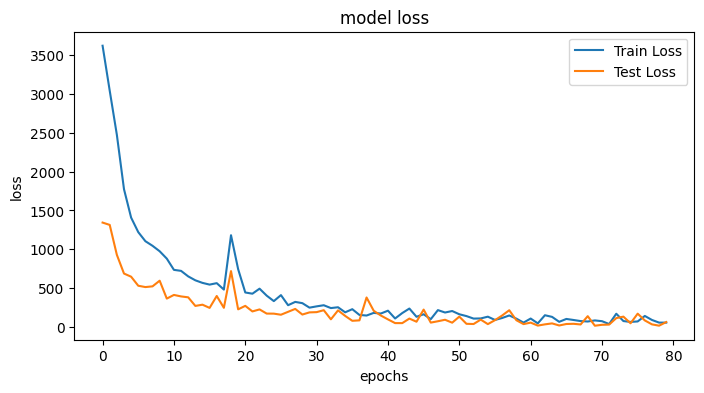

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

1030/1030 [==============================] - 12s 11ms/step


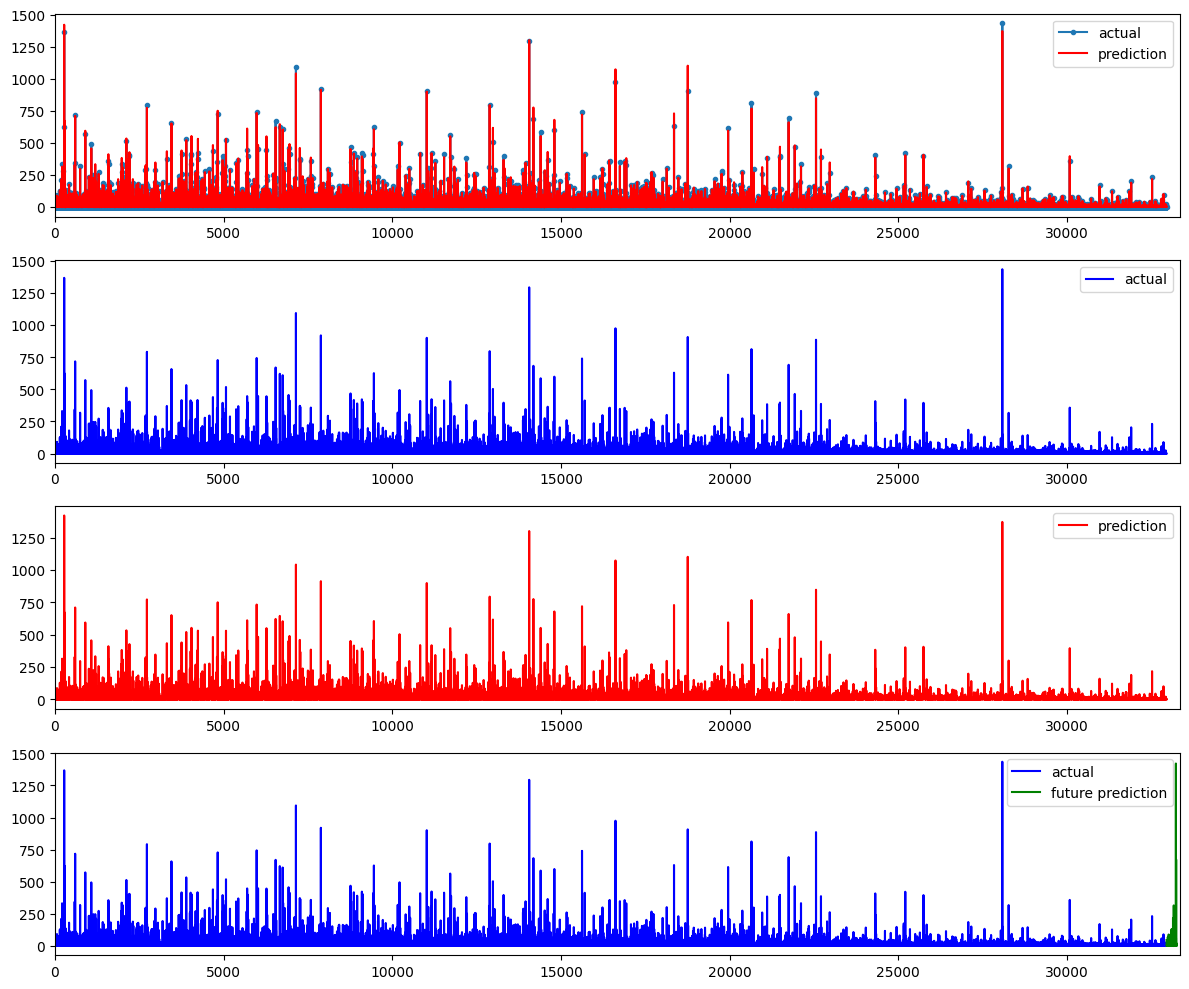

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,10)

aa=[x for x in range(X_test.shape[0])]
# number of future prediction
n_steps = 300
ab=[x+aa[-1]+1 for x in range(n_steps)]

# Plot 1 - Test and predictions
plt.subplot(4, 1, 1)
plt.plot(aa, y_test, marker='.', label="actual")
plt.plot(aa, y_test_pred, 'r', label="prediction")
plt.legend()
plt.xlim(aa[0], ab[-1]+100)

# Plot 2 - Just test data
plt.subplot(4, 1, 2)
plt.plot(aa, y_test, 'b', label="actual")
plt.legend()
plt.xlim(aa[0], ab[-1]+100)

# Plot 3 - Just predictions
plt.subplot(4, 1, 3)
plt.plot(aa, y_test_pred, 'r', label="prediction")
plt.legend()
plt.xlim(aa[0], ab[-1]+100)

# Plot 4 - Test and future predictions
plt.subplot(4, 1, 4)
X_future = X_test[:, -n_steps:]
y_future = model.predict(X_future)
y_future = y_future[:n_steps]
plt.plot(aa, y_test, 'b', label="actual")
plt.plot(ab, y_future, 'g', label="future prediction")
plt.legend()
plt.xlim(aa[0], ab[-1]+100)

# Show plots
plt.tight_layout()
plt.show()

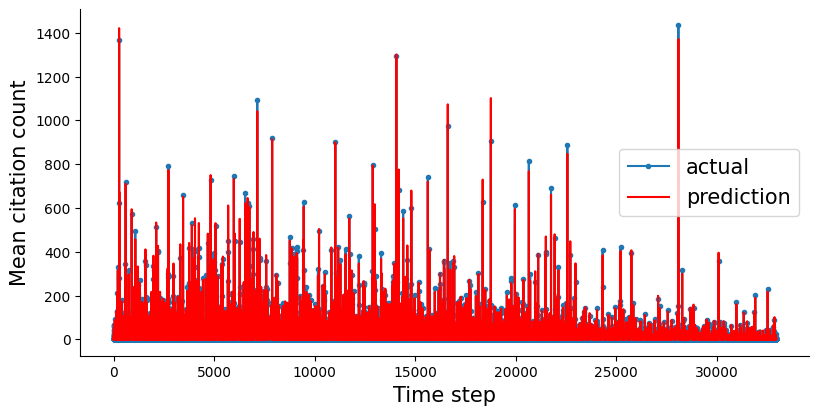

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

length = X_test.shape[0]
aa=[x for x in range(length)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_test[:length], marker='.', label="actual")
plt.plot(aa, y_test_pred[:,0][:length], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Mean citation count', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

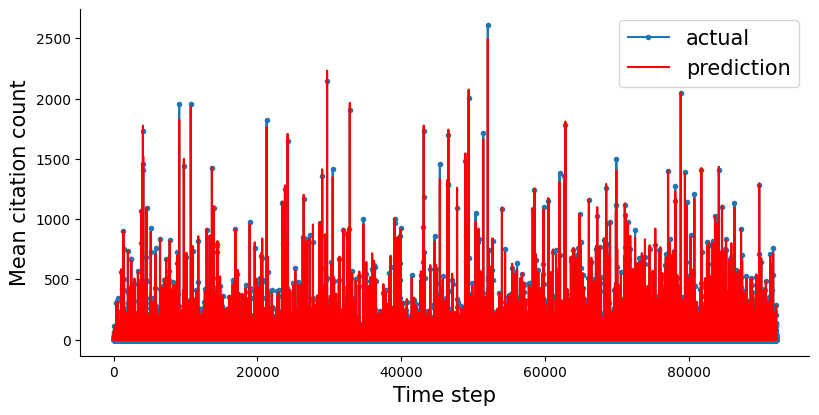

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

length = X_train.shape[0]
aa=[x for x in range(length)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_train[:length], marker='.', label="actual")
plt.plot(aa, y_train_pred[:,0][:length], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Mean citation count', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();